In [1]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from math import atan2, degrees
import glob,os
from natsort import natsorted
import cv2
from matplotlib import pyplot as plt

In [2]:
src = r'\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined'
dst = os.path.join(src, 'crop_TA/tmp')
if not os.path.exists(dst): os.mkdir(dst)
imlist = glob.glob(os.path.join(src,'*.tif'))
imlist = natsorted(imlist)
minTA = 60000
minTAhole = 100
minDermhole = 5000
minepisize=1000
whitespace=12

In [3]:
df=[]
for imidx,imname in enumerate(imlist):
    fn, ext = os.path.splitext(os.path.basename(imname))
    if os.path.exists(os.path.join(dst, '{}_sec{:02d}.png'.format(fn, 1))):
        print('continue')
        continue
    # open image
    im = Image.open(imname)
    TAbig = np.array(im)
    # downsize to expedite
    (width, height) = (im.width // 10, im.height // 10)
    im_resized = im.resize((width, height), resample=0)
    TA = np.array(im_resized)
    sure_fg = closing((2 < TA) & (TA < whitespace - 1), square(3))  # 13sec
    sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec
    sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole).astype(np.uint8)  # 7sec
    # define background
    bw = closing(TA < whitespace, square(3))  # 12 is background
    bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
    bw = remove_small_holes(bw, area_threshold=minTAhole)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    # define middleground
    unknown = cv2.subtract(sure_bg, sure_fg).astype('bool')
    # label that background is 1 and objects are 2~N and middleground is zero
    sure_fg_label = label(sure_fg).astype(np.int32)
    sure_fg_label = sure_fg_label + 1
    sure_fg_label[unknown] = 0
    # perform watershed based on the marker
    TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR)
    label_image = cv2.watershed(TAbgr, sure_fg_label)
    # iterate each section
    epi = (TA == 1) | (TA == 2)
    derm = (2 < TA) & (TA < whitespace)
    derm = remove_small_holes(derm, area_threshold=minDermhole)
    epi2 = epi & ~derm
    epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)
    numsecmax = np.max(label_image)
    for numsec in range(1,numsecmax):
        print('section N: ', numsec, '/', numsecmax-1)
        msktmp = label_image == numsec+1
        mskepi = msktmp & epi2
        # align horizontal
        [xt2, yt2] = np.where(mskepi)
        vertices = np.array([xt2[::10], yt2[::10]]).T
        vc = vertices - vertices.mean(axis=0)
        if not vertices.any():
            print(imidx,numsec)
            # raise Exception("tissue is erased unintentionally")
        U, S, Vt = np.linalg.svd(vc)
        k = Vt.T
        d0 = degrees(atan2(k[1, 1], k[1, 0]))
        if np.linalg.det(k)<0: d0=-d0
        if d0<0: d0=d0+360
        k=k.flatten()
        #add to dataframes
        df.append({'imID':imidx,'imname': fn, 'secN': numsec,'k':k.flatten(),'degrot': round(d0,2)})
        df2 = pd.DataFrame(df)
        df2.to_csv(os.path.join(dst,'CLUEdegrot.csv'))

section N:  1 / 1
section N:  1 / 1
section N:  1 / 1
section N:  1 / 1
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 2
section N:  2 / 2
section N:  1 / 5
section N:  2 / 5
section N:  3 / 5
section N:  4 / 5
section N:  5 / 5
section N:  1 / 1
section N:  1 / 2
section N:  2 / 2
section N:  1 / 2
section N:  2 / 2
section N:  1 / 2
section N:  2 / 2
section N:  1 / 2
section N:  2 / 2
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 3
section N:  2 / 3
section N:  3 / 3
section N:  1 / 3
section N:  2 / 3
section N:  3 / 3
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 5
section N:  2 / 5
section N:  3 / 5
section N:  4 / 5
section N:  5 / 5
section N:

C:\Users\kyuha\AppData\Local\Temp\ipykernel_8524\1348606784.py:47: RuntimeWarning: Mean of empty slice.
  vc = vertices - vertices.mean(axis=0)
C:\Users\kyuha\anaconda3\envs\wsi_analysis\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 1
section N:  1 / 2
section N:  2 / 2
section N:  1 / 2
section N:  2 / 2
section N:  1 / 5
section N:  2 / 5
section N:  3 / 5
section N:  4 / 5
section N:  5 / 5
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 2
section N:  2 / 2
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 2
section N:  2 / 2
section N:  1 / 4
43 1
section N:  2 / 4
section N:  3 / 4


C:\Users\kyuha\AppData\Local\Temp\ipykernel_8524\1348606784.py:47: RuntimeWarning: Mean of empty slice.
  vc = vertices - vertices.mean(axis=0)
C:\Users\kyuha\anaconda3\envs\wsi_analysis\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 6
section N:  2 / 6
section N:  3 / 6
section N:  4 / 6
section N:  5 / 6
section N:  6 / 6
48 6


C:\Users\kyuha\AppData\Local\Temp\ipykernel_8524\1348606784.py:47: RuntimeWarning: Mean of empty slice.
  vc = vertices - vertices.mean(axis=0)
C:\Users\kyuha\anaconda3\envs\wsi_analysis\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


section N:  1 / 3
section N:  2 / 3
section N:  3 / 3
section N:  1 / 5
section N:  2 / 5
section N:  3 / 5
section N:  4 / 5
section N:  5 / 5
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 2
section N:  2 / 2
section N:  1 / 1
section N:  1 / 1
section N:  1 / 2
section N:  2 / 2
section N:  1 / 1
section N:  1 / 1
section N:  1 / 4
section N:  2 / 4
section N:  3 / 4
section N:  4 / 4
section N:  1 / 1


In [4]:
imname=imlist[4]
fn, ext = os.path.splitext(os.path.basename(imname))
# open image
im = Image.open(imname)
TAbig = np.array(im)
# downsize to expedite
(width, height) = (im.width // 10, im.height // 10)
im_resized = im.resize((width, height), resample=0)
TA = np.array(im_resized)
sure_fg = closing((2 < TA) & (TA < whitespace - 1), square(3))  # 13sec
sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec
sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole).astype(np.uint8)  # 7sec
# define background
bw = closing(TA < whitespace, square(3))  # 12 is background
bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
bw = remove_small_holes(bw, area_threshold=minTAhole)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
sure_bg = cv2.dilate(opening, kernel, iterations=3)
# define middleground
unknown = cv2.subtract(sure_bg, sure_fg).astype('bool')
# label that background is 1 and objects are 2~N and middleground is zero
sure_fg_label = label(sure_fg).astype(np.int32)
sure_fg_label = sure_fg_label + 1
sure_fg_label[unknown] = 0
# perform watershed based on the marker
TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR)
label_image = cv2.watershed(TAbgr, sure_fg_label)
# iterate each section
epi = (TA == 1) | (TA == 2)
derm = (2 < TA) & (TA < whitespace)
derm = remove_small_holes(derm, area_threshold=minDermhole)
epi2 = epi & ~derm
epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)
numsecmax = np.max(label_image)
numsec=4
print('section N: ', numsec, '/', numsecmax-1)
msktmp = label_image == numsec+1
mskepi = msktmp & epi2
# align horizontal
[xt2, yt2] = np.where(mskepi)
vertices = np.array([xt2[::10], yt2[::10]]).T
vc = vertices - vertices.mean(axis=0)
if not vertices.any():
    print(imidx,numsec)
    # raise Exception("tissue is erased unintentionally")
U, S, Vt = np.linalg.svd(vc)
k = Vt.T
d0 = degrees(atan2(k[1, 1], k[1, 0]))
if np.linalg.det(k)<0: d0=-d0
print(d0)

section N:  4 / 4
-165.04876239436328


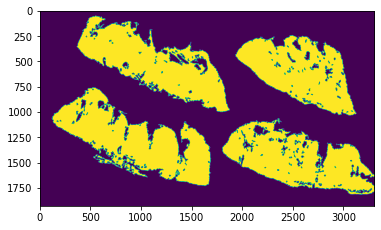

In [9]:
sure_fg = closing((2 < TA) & (TA < whitespace - 1), square(3))  # 13sec
sure_fg = remove_small_objects(sure_fg, min_size=60000, connectivity=2)  # 6sec
sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole).astype(np.uint8)  # 7sec
plt.imshow(sure_fg)